In [66]:
import os
import cv2
import geopandas as gpd
import numpy as np
from rasterio import features
from tqdm import tqdm
from shapely.ops import cascaded_union
from itertools import combinations
from shapely.affinity import translate
from shapely.geometry import Polygon, LineString, Point, MultiPoint
import geopandas as gpd
import rasterio
import shutil
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
raster_mask = "/mnt/storage_4tb/ymi/geo_data/40m_for_ori/citrusuco/v5_tta_full_504/rgb_504_rgg_bin.tif"
rows_path = "/mnt/storage_4tb/ymi/geo_data/40m_for_ori/citrusuco/row_data/504/row_data.geojson"
detected_polygon_path = "/mnt/storage_4tb/ymi/geo_data/40m_for_ori/citrusuco/row_data/504/detected_polygon.geojson"

In [3]:
row_df = gpd.read_file(rows_path)
dataset = rasterio.open(raster_mask, "r")

In [4]:
def points_to_image_view(points, rect, dataset):
    col_offset = rect[0]
    row_offset = rect[1]
    img_polyg_array = []
    to_img_mat = ~dataset.meta['transform']
    for item in points.iterrows():
        polyg_spati = np.array(item[1]['geometry'].coords)
        polyg_img = [tuple(pt) * to_img_mat for pt in polyg_spati]
        polyg_img = np.subtract(polyg_img, (col_offset, row_offset))
        polyg_img = LineString(polyg_img)
        # polyg_img = polyg_img.convex_hull
        img_polyg_array.append(polyg_img)

    return img_polyg_array

In [5]:
def lines_to_image_view(points, dataset, rect=None):
    if rect:
        col_offset = rect[0]
        row_offset = rect[1]
    img_polyg_array = []
    to_img_mat = ~dataset.meta['transform']
    for item in points.iterrows():
        polyg_spati = np.array(item[1]['geometry'].coords)
        polyg_img = [tuple(pt) * to_img_mat for pt in polyg_spati]
        if rect:
            polyg_img = np.subtract(polyg_img, (col_offset, row_offset))
        polyg_img = LineString(polyg_img)
        # polyg_img = polyg_img.convex_hull
        img_polyg_array.append(polyg_img)

    return img_polyg_array

In [15]:
rows_img = lines_to_image_view(row_df, dataset, rect=None)

In [16]:
all_pts = []
for row in row_df['geometry'].values:
    row_pts = [Point(c) for c in row.coords]
    all_pts.extend(row_pts)
    
all_pts_multipoint = MultiPoint(all_pts)

In [18]:
all_endpts = []
for row in rows_img:
    row_pts = [Point(row.coords[0]), Point(row.coords[-1])]
    all_endpts.extend(row_pts)

In [9]:
len(row_df['geometry'].values)

86

In [19]:
len(all_endpts)

172

In [22]:
from shapely.ops import nearest_points

In [49]:
num_y = np.arange(300)
num_x = np.arange(300)
grid_x, grid_y = np.meshgrid(num_x, num_y)

In [56]:
sampling_grid = np.vstack([grid_x.flatten(), grid_y.flatten()]).T

In [57]:
sampling_grid.shape

(90000, 2)

In [75]:
img = np.zeros((300, 300), dtype=np.int64)
for pt in tqdm_notebook(sampling_grid):
    pt_shp = Point(pt)
    min_dist = 10000
    row = None
    for num, row in enumerate(rows_img):
        nearest_pt = nearest_points(pt_shp, row)[1]
        length = LineString((pt_shp, nearest_pt)).length
        if length < min_dist:
            min_dist = length
            row = num
        #break
    #print(min_dist)
    img[pt[0], pt[1]] = min_dist
    #break

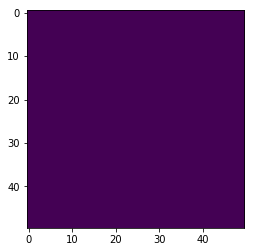

In [76]:
plt.imshow(img[:50, :50])

In [ ]:
np = nearest_points(line, p)[0]

In [11]:
hull = all_pts_multipoint.envelope

In [12]:
not_contained = [p for p in all_pts if not hull.buffer(-0.5).contains(p)]

In [68]:
detected_polygon_path = "/mnt/storage_4tb/ymi/geo_data/40m_for_ori/citrusuco/angle_training_180/504/end_pts.geojson"

polygon_df = gpd.GeoDataFrame(geometry=all_endpts)
polygon_df.crs = dataset.meta.get('crs')
if os.path.exists(detected_polygon_path):
    os.remove(detected_polygon_path)
polygon_df.to_file(detected_polygon_path, driver='GeoJSON', encoding='utf-8')

In [2]:
def dist(a, b):
    """
    Distance between two points
    """
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)


def img_to_proba(centers, polys, shape):
    """
    Calculates a "probability" of a polygon center

    :param centers: list of polygon centers
    :param polys: list of polygons
    :param shape: image shape
    :return: array with tree center probabilities
    """
    dist_mask = np.expand_dims(np.zeros(shape), axis=2)
    for polygon, center in zip(polys, centers):
        if len(polygon.bounds) == 0:
            continue
        minx, miny, maxx, maxy = [int(x) for x in polygon.bounds]
        # make sure we are in bounds
        minx = np.clip(minx, 0, shape[1])
        maxx = np.clip(maxx, 0, shape[1])
        miny = np.clip(miny, 0, shape[0])
        maxy = np.clip(maxy, 0, shape[0])

        mask = features.rasterize([polygon], shape).astype("float32")
        window = mask[miny : maxy + 1, minx : maxx + 1].copy()
        window_binary = window.copy()
        offset_center = [center[1] - miny, center[0] - minx]

        tree = np.nonzero(window)
        for x, y in zip(tree[0], tree[1]):
            window[x, y] = dist([x, y], offset_center)
        try:
            window = window / window.max()
        except:
            continue
        if not np.isfinite(dist_mask).all():
            continue

        window = np.ones_like(window) - window
        mask[miny : maxy + 1, minx : maxx + 1] = window * window_binary
        dist_mask = np.concatenate([dist_mask, np.expand_dims(mask, axis=2)], axis=2)

        dist_mask = np.max(dist_mask, axis=2, keepdims=True)
    return dist_mask